# DRL Course 2023 Домашнее задание 3 #

Отчет по выполнению домашнего задания, Nikita Sorokin

## Задание 1 
В алгоритме Policy Iteration важным гиперпараметром является gamma. Требуется ответить на вопрос, какой gamma лучше выбирать. Качество обученной политики можно оценивать например запуская среду 1000 раз и взяв после этого средний total_reward. 

Описание алгоритма:

Введем две функции:

$$
v_\pi(s) := \mathbb{E}_\pi[G|S_0=s], \quad q_\pi(s, a) := \mathbb{E}_\pi[G|S_0=s, A_0=a]
$$

Для них можно записать уравнения Беллмана:

$$ 
v_\pi(s) = \sum_a \pi(a|s) \Big( R(s, a) + \gamma \sum_{s'} P(s' | s, a) v_\pi(s') \Big) \\[6pt]
q_\pi(s, a) = R(s, a) + \gamma \sum_{s'} P(s' | s, a) \sum_{a'} \pi(a'|s') q_\pi (s', a') \\[6pt]
$$

Из этих соотношений находится связь между функциями $ v_\pi(s) $ и $ q_\pi(s) $:

$$
v_\pi(s) = \sum_a \pi(a|s) q_\pi(s, a) \\[6pt]
q_\pi(s, a) = R(s, a) + \gamma \sum_{s'} P(s' | s, a)  v_\pi(s')
$$

В поставленной задачи награда зависит от следующего состояния поэтому полученная формула для $v_\pi(s) $ примут вид:

$$
q_\pi(s,a) = \sum_{s'} P(s'|s,a) \Big( R(s,a,s') + \gamma v_\pi (s')\Big)
$$

### Policy Iteration:

1. (Policy Evaluation) 
$$
v_{\pi}^{l + 1}(s) = \sum_a \pi(a|s) q_{\pi}^{l} (s, a), \quad l \in \overline{0, L-1} 
$$  

Находим $ q_{\pi}^{L}(s, a) $ по $ v_{\pi}^{L}(s) $

2. (Policy Improvement)

$$

\pi^{k + 1}(a|s) =

\begin{cases}
1, \text{if} \,\, a \in argmax_{a' \in A} q_{\pi}^{L} (s, a') \\
0, \text{else} \\
\end{cases}

$$

In [1]:
import numpy as np
import time
import os
from tqdm import tqdm
from Frozen_Lake import FrozenLakeEnv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()

In [2]:
env = FrozenLakeEnv()

In [3]:
class DPAgent():
    def __init__(self, env):
        self.env = env
        self.policy = self.init_policy()

    def init_policy(self):
        policy = {}
        for state in self.env.get_all_states():
            policy[state] = {}
            for action in self.env.get_possible_actions(state):
                policy[state][action] = 1 / len(self.env.get_possible_actions(state))
        return policy

    def init_v_values(self):
        v_values = {}
        for state in self.env.get_all_states():
            v_values[state] = 0
        return v_values

    def get_q_values(self, v_values, gamma):
        q_values = {}
        for state in self.env.get_all_states():
            q_values[state] = {}
            for action in self.env.get_possible_actions(state):
                q_values[state][action] = 0
                for next_state in self.env.get_next_states(state, action):
                    q_values[state][action] += self.env.get_transition_prob(state, action, next_state) * self.env.get_reward(state, action, next_state)
                    q_values[state][action] += gamma * self.env.get_transition_prob(state, action, next_state) * v_values[next_state]
        return q_values

    def policy_evaluation_step(self, v_values, policy, gamma, algo):
        q_values = self.get_q_values(v_values, gamma)
        new_v_values = self.init_v_values()
        for state in self.env.get_all_states():
            new_v_values[state] = 0
            if algo == 'policy':
                for action in self.env.get_possible_actions(state):
                    new_v_values[state] += policy[state][action] * q_values[state][action]
            if algo == 'value':
                try:
                    new_v_values[state] = max(q_values[state].values())
                except Exception:
                    new_v_values[state] = 0

        return new_v_values
        
    def policy_evaluation(self, policy, gamma, eps, v_values, algo):
        new_v_values = self.policy_evaluation_step(v_values, policy, gamma, algo)
        delta_v = abs(np.array(list(v_values.values())) - np.array(list(new_v_values.values())))

        while(max(delta_v) > eps):
            v_values = new_v_values
            new_v_values = self.policy_evaluation_step(v_values, policy, gamma, algo)
            delta_v = abs(np.array(list(v_values.values())) - np.array(list(new_v_values.values())))

        q_values = self.get_q_values(v_values, gamma)

        return q_values, v_values

    def policy_improvement(self, q_values):
        policy = {}
        for state in self.env.get_all_states():
            policy[state] = {}
            argmax_action = None
            max_q_value = float('-inf')
            for action in self.env.get_possible_actions(state): 
                policy[state][action] = 0
                if q_values[state][action] > max_q_value:
                    argmax_action = action
                    max_q_value = q_values[state][action]
            policy[state][argmax_action] = 1

        return policy

    def train(self, iter_n, eps, gamma, algo, save_v_values=False):
        policy = self.init_policy()
        v_values = self.init_v_values()
        for _ in range(iter_n):
            if save_v_values == False:
                v_values = self.init_v_values()
            q_values, v_values = self.policy_evaluation(policy, gamma, eps, v_values, algo)
            policy = self.policy_improvement(q_values)

        self.policy = policy

        return policy

    def validation(self, validation_n):
        total_rewards = []
        for _ in range(validation_n):
            total_reward = 0
            state = self.env.reset()
            while(True):
                action = np.random.choice(self.env.get_possible_actions(state), p=list(self.policy[state].values()))
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            total_rewards.append(total_reward)

        return np.mean(total_rewards)

    def visualize_trajectory(self, policy):
        total_reward = 0
        state = self.env.reset()
        done = False
        while(done == False):
            action = np.random.choice(self.env.get_possible_actions(state), p=list(policy[state].values()))
            state, reward, done, _ = self.env.step(action)
            total_reward += reward

            clear_output(wait=True)
            self.env.render()
            time.sleep(1)
            
            if done:
                break

Посмотрим сколько итераций mean total reward от количества итераций алгоритма при фиксированных $ \gamma $ и $ \varepsilon $:

In [4]:
def iter_n_search(max_iter, eps, gamma, algo, validation_n, save_v_values=False):
    
    fig, axs = plt.subplots(figsize=(10, 6))

    mean_rewards = []
    for iter in range(0, max_iter + 1):
        agent = DPAgent(env)
        agent.train(iter, eps, gamma, algo, save_v_values)
        mean_total_reward = agent.validation(validation_n)
        mean_rewards.append(mean_total_reward)
    
    iters = np.arange(0, max_iter + 1)

    axs.set_xlabel('algorithm iteration')
    axs.set_ylabel('mean total reward')
    axs.plot(iters, mean_rewards, label=f'eps={eps}, gamma={gamma}')
    plt.legend()
    plt.savefig('iter_n_search.png')

    return mean_rewards

[0.01, 0.74, 0.86, 0.93, 0.89, 0.98, 0.87, 0.97, 0.84, 0.95, 0.81, 0.99, 0.85, 0.98, 0.86, 0.99, 0.93, 0.94, 0.86, 0.97, 0.91]


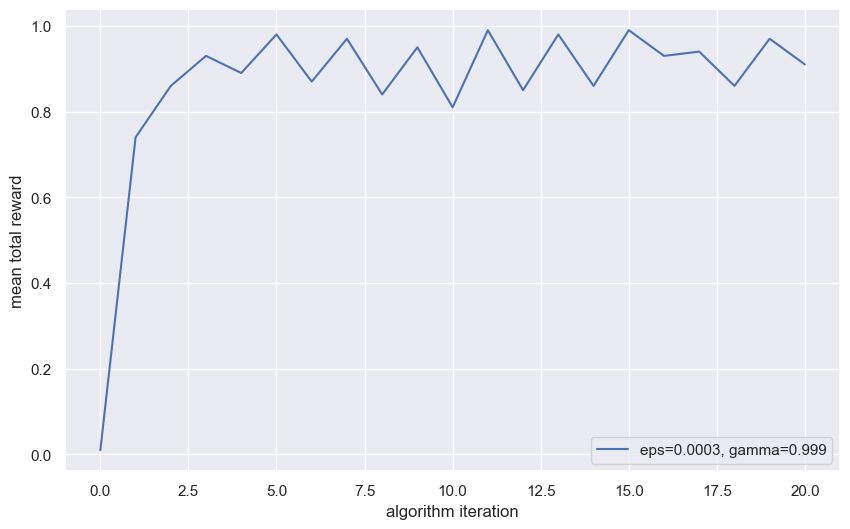

In [5]:
max_iter = 20
eps = 0.0003
gamma = 0.999
algo = 'policy'
validation_n = 100

mean_rewards = iter_n_search(max_iter, eps, gamma, algo, validation_n)
print(mean_rewards)

Можно сделать вывод, что с примерно с третьей итерации алгоритм выходит на плато. Будем использовать iter_n = 5

С помощью grid-search будем искать наилучшие параметры $ \gamma $ и $ \varepsilon $:

In [6]:
def grid_search(iter_n, params, algo, validation_n):

    results = np.zeros((params['gamma'].size, params['eps'].size))

    for i, gamma in tqdm(enumerate(params['gamma'])):
        for j, eps in enumerate(params['eps']):
            agent = DPAgent(env)
            policy = agent.train(iter_n, eps, gamma, algo)
            mean_total_reward = agent.validation(validation_n)
            results[i][j] = mean_total_reward

    return results

In [7]:
params = {
    'gamma': np.array([0.9, 0.99, 0.9999, 1]),
    'eps': np.array([0.03, 0.0003, 0.000003])
}

In [8]:
iter_n = 5
algo = 'policy'
validation_n = 1000

results = grid_search(iter_n, params, algo, validation_n)

0it [00:00, ?it/s]

4it [01:29, 22.25s/it]


In [9]:
for i, gamma in enumerate(params['gamma']):
    for j, eps in enumerate(params['eps']):
        print(f'gamma = {gamma},\t eps = {eps}: \t mean_total_reward = {results[i, j]}')

gamma = 0.9,	 eps = 0.03: 	 mean_total_reward = 0.747
gamma = 0.9,	 eps = 0.0003: 	 mean_total_reward = 0.735
gamma = 0.9,	 eps = 3e-06: 	 mean_total_reward = 0.723
gamma = 0.99,	 eps = 0.03: 	 mean_total_reward = 0.746
gamma = 0.99,	 eps = 0.0003: 	 mean_total_reward = 0.84
gamma = 0.99,	 eps = 3e-06: 	 mean_total_reward = 0.849
gamma = 0.9999,	 eps = 0.03: 	 mean_total_reward = 0.739
gamma = 0.9999,	 eps = 0.0003: 	 mean_total_reward = 0.997
gamma = 0.9999,	 eps = 3e-06: 	 mean_total_reward = 0.996
gamma = 1.0,	 eps = 0.03: 	 mean_total_reward = 0.733
gamma = 1.0,	 eps = 0.0003: 	 mean_total_reward = 0.995
gamma = 1.0,	 eps = 3e-06: 	 mean_total_reward = 0.995


Следовательно, лучшие параметрами являются: $ \gamma = 0.9999 $ и $ \varepsilon = 0.000006 $

## Задание 2

На шаге Policy Evaluation мы каждый раз начинаем с нулевых values. А что будет если вместо этого начинать с values обученных на предыдущем шаге? Будет ли алгоритм работать? Если да, то будет ли он работать лучше? 

В функцию train добавим условие при выполнении которого v_values будут не обнуляться, а передаваться  в следующую итерациюк policy_evaluation.

Реализация:

```python
    def train(self, iter_n, eps, gamma, algo, save_v_values=False):

        ...

        for _ in range(iter_n):

            if save_v_values == False:
                v_values = self.init_v_values()

            q_values, v_values = self.policy_evaluation(policy, gamma, eps, v_values, algo)
            policy = self.policy_improvement(q_values)

        ...

        return policy
```

In [10]:
def grid_search(iter_n, params, algo, validation_n):

    results = np.zeros((params['gamma'].size, params['eps'].size, 2))

    for i, gamma in tqdm(enumerate(params['gamma'])):
        for j, eps in enumerate(params['eps']):
            agent1 = DPAgent(env)
            agent2 = DPAgent(env)
            agent1.train(iter_n, eps, gamma, algo, save_v_values=False)
            agent2.train(iter_n, eps, gamma, algo, save_v_values=True)
            mean_total_reward1 = agent1.validation(validation_n)
            mean_total_reward2 = agent2.validation(validation_n)
            results[i][j][0] = mean_total_reward1
            results[i][j][1] = mean_total_reward2

    return results

In [11]:
params = {
    'gamma': np.array([0.99, 0.9999]),
    'eps': np.array([0.003, 0.000003])
}

In [12]:
iter_n = 10
algo = 'policy'
validation_n = 1000

results = grid_search(iter_n, params, algo, validation_n)

0it [00:00, ?it/s]

2it [00:45, 22.64s/it]


In [13]:
for i, gamma in enumerate(params['gamma']):
    for j, eps in enumerate(params['eps']):
        print(f'gamma = {gamma},\t eps = {eps}, \t save_v_values = False:\t mean_total_reward = {results[i, j, 0]}')
        print(f'gamma = {gamma},\t eps = {eps}, \t save_v_values = True: \t mean_total_reward = {results[i, j, 1]} \n')

gamma = 0.99,	 eps = 0.003, 	 save_v_values = False:	 mean_total_reward = 0.746
gamma = 0.99,	 eps = 0.003, 	 save_v_values = True: 	 mean_total_reward = 0.851 

gamma = 0.99,	 eps = 3e-06, 	 save_v_values = False:	 mean_total_reward = 0.864
gamma = 0.99,	 eps = 3e-06, 	 save_v_values = True: 	 mean_total_reward = 0.839 

gamma = 0.9999,	 eps = 0.003, 	 save_v_values = False:	 mean_total_reward = 0.872
gamma = 0.9999,	 eps = 0.003, 	 save_v_values = True: 	 mean_total_reward = 0.969 

gamma = 0.9999,	 eps = 3e-06, 	 save_v_values = False:	 mean_total_reward = 0.996
gamma = 0.9999,	 eps = 3e-06, 	 save_v_values = True: 	 mean_total_reward = 0.996 



Можно подобрать такие значения $ \varepsilon $ и $ \gamma $, что mean_total_reward значительно больше у агента, который запоминает v_values. Однако в целом, в заданной среде различия не так существенны и даже подобрать такие значения довольно проблематично.

## Задание 3 

Написать Value Iteriation. Исследовать гиперпараметры (в том числе gamma). Cравнить с Policy Iteration. Поскольку в Policy Iteration есть еще внутренний цикл, то адекватным сравнением алгоритмов будет не графики их результативности относительно внешнего цикла, а графики относительно, например, количества обращения к среде. 

Определим 2 новые функции:

$$
v_{*}(s) = \underset{\pi}{max} \, v_{\pi}(s), \quad q_{*}(s, a) = \underset{\pi}{max} \, v_{\pi}(s, a)
$$

Связь между ними выводится из соответствующих уравнений Беллмана:

$$
v_{*}(s) = \underset{a \in A}{max} \, q_{*}(s, a), \quad q_{*}(s, a) = R(s, a) + \gamma \sum_{s'} P(s'|s, a) v_{*}(s')
$$

В алгоритме Value Iteration вычисляются функции $ v_{*}(s), \,\,  q_{*}(s, a) $ в то время как в алгоритме Policy Iteration вычисляются  $ v_{\pi}(s), \,\,  q_{\pi}(s, a) $. Так как формулы вычисления $ q(s,a) $ по $ v(s) $ совпадают в написанной реализации Policy Iteration надо только изменить формулу вычисления $ v(s) $ по $ q(s, a) $.

Реализация:

```python
    def policy_evaluation_step(self, v_values, policy, gamma, algo):

            ...

            if algo == 'policy':
                for action in self.env.get_possible_actions(state):
                    new_v_values[state] += policy[state][action] * q_values[state][action]
            if algo == 'value':
                try:
                    new_v_values[state] = max(q_values[state].values())
                except Exception:
                    new_v_values[state] = 0
```

[0.015, 0.964, 0.965, 0.969, 0.978, 0.966, 0.974, 0.973, 0.97, 0.971, 0.972, 0.955, 0.956, 0.963, 0.963, 0.968, 0.97, 0.966, 0.976, 0.964, 0.962]


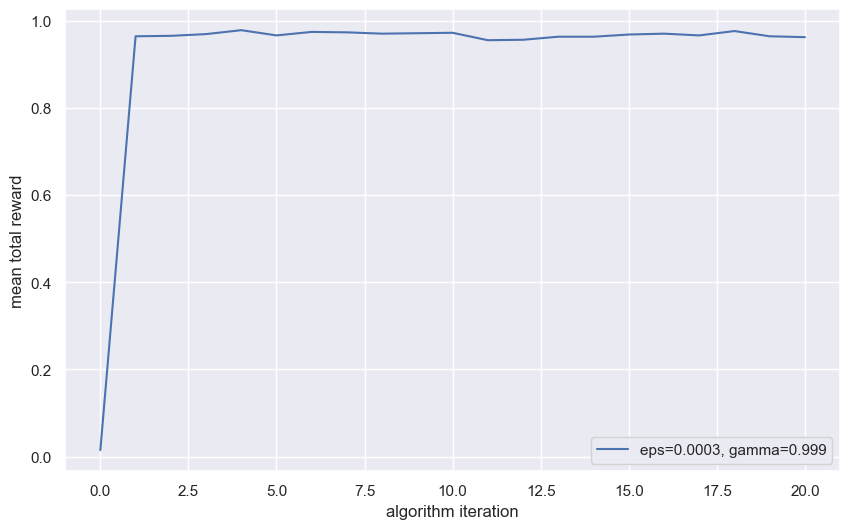

In [14]:
max_iter = 20
eps = 0.0003
gamma = 0.999
algo = 'value'
validation_n = 1000

mean_rewards = iter_n_search(max_iter, eps, gamma, algo, validation_n)
print(mean_rewards)

Алгоритм сходится к оптимальной политики со второго шага. В дальнейшем будем рассматривать iter_n = 5. 

In [15]:
def grid_search(iter_n, params, validation_n):

    results = np.zeros((params['gamma'].size, params['eps'].size, 2))

    for i, gamma in tqdm(enumerate(params['gamma'])):
        for j, eps in enumerate(params['eps']):
            agent1 = DPAgent(env)
            agent2 = DPAgent(env)
            agent1.train(iter_n, eps, gamma, algo='policy')
            agent2.train(iter_n, eps, gamma, algo='value')
            mean_total_reward1 = agent1.validation(validation_n)
            mean_total_reward2 = agent2.validation(validation_n)
            results[i][j][0] = mean_total_reward1
            results[i][j][1] = mean_total_reward2

    return results

In [16]:
params = {
    'gamma': np.array([0.99, 0.9999]),
    'eps': np.array([0.003, 0.000003])
}

In [17]:
iter_n = 5
validation_n = 1000

results = grid_search(iter_n, params, validation_n)

2it [00:44, 22.37s/it]


In [18]:
for i, gamma in enumerate(params['gamma']):
    for j, eps in enumerate(params['eps']):
        print(f'gamma = {gamma},\t eps = {eps}, \t algo = \'policy\': mean_total_reward = {results[i, j, 0]}')
        print(f'gamma = {gamma},\t eps = {eps}, \t algo = \'value\' : mean_total_reward = {results[i, j, 1]} \n')

gamma = 0.99,	 eps = 0.003, 	 algo = 'policy': mean_total_reward = 0.843
gamma = 0.99,	 eps = 0.003, 	 algo = 'value' : mean_total_reward = 0.871 

gamma = 0.99,	 eps = 3e-06, 	 algo = 'policy': mean_total_reward = 0.862
gamma = 0.99,	 eps = 3e-06, 	 algo = 'value' : mean_total_reward = 0.863 

gamma = 0.9999,	 eps = 0.003, 	 algo = 'policy': mean_total_reward = 0.975
gamma = 0.9999,	 eps = 0.003, 	 algo = 'value' : mean_total_reward = 0.87 

gamma = 0.9999,	 eps = 3e-06, 	 algo = 'policy': mean_total_reward = 0.996
gamma = 0.9999,	 eps = 3e-06, 	 algo = 'value' : mean_total_reward = 0.998 

